# CIFAR10 dataset classification using Pytorch.
We will achieve deep understanding of the dataset and try to achieve the best accuracy with minimum time/energy.

### Imports

In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import sys
from pathlib import Path

module_path = str(Path().resolve().parents[0]) 
print(module_path)
# Add the directory to sys.path
sys.path.insert(0, module_path)

from utils import image_utils

C:\Users\reuve\PycharmProjects\PyTorch\my_projects


### Set the path, processing device, and download data using Pytorch built-in dataset class

In [2]:
# Set the directory for data.
current_dir = os.getcwd()
data_path = f"{current_dir}\\..\\..\\data"
print(data_path)

# Check whether we can run on GPU (preferred) or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Download the raw data.
train_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor()) # This transform also normalizes to 0-1
test_dataset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transforms.ToTensor())

# Save the image size.
image_size = train_dataset.data[0].shape
print(image_size)

# The the number of classes.
num_classes = len(train_dataset.classes)
print(num_classes)

class_names = train_dataset.classes
print(class_names)

C:\Users\reuve\PycharmProjects\PyTorch\my_projects\CNN_models\data
cuda
(32, 32, 3)
10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### View a bunch of images

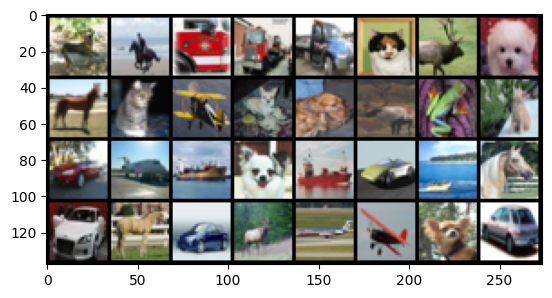

In [3]:
# Test a bunch of images.
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(dataloader)
images, labels = next(dataiter)
PIL_image = transforms.ToPILImage() # Convert from tensor back to 0 - 255 uint8 values. 
pets_input_grid = torchvision.utils.make_grid(images, nrow=batch_size // 4) # make_grid concatenates all images to one large image.
plt.imshow(PIL_image(pets_input_grid))

### Optional: check the mean and std of each RGB channel for standardization

In [47]:
full_dataset = train_dataset + test_dataset
mean, std = image_utils.image_dataset_mean_std(full_dataset)
print(f"mean vals:{mean}")
print(f"std vals:{std}")

==> Computing mean and std..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:35<00:00, 1693.74it/s]


mean/std channels values are: tensor([0.4919, 0.4827, 0.4472]) 
 tensor([0.2023, 0.1994, 0.2010])
time elapsed [s]:  35.43661022186279
mean vals:tensor([0.4919, 0.4827, 0.4472])
std vals:tensor([0.2023, 0.1994, 0.2010])


### Set the transform for the standardized data.
Common value chosen (based on ImageNet) are: mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225].
But we'll use the values from above

In [80]:
transform = transforms.Compose(
    [transforms.ToTensor(), # normalizes to 0 to 1 range.
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2023, 0.1994, 0.2010))]) 

train_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform) 
test_dataset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

### Define the dataloaders.
dataloaders convert the datasets to iterable tuples of (images, labels)

In [81]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Single-layer CNN model

In [6]:
# The number of convolution features (channels) can and should be optimized.
class single_layer_cnn(nn.Module): 
    def __init__(self, input_size_dims, num_classes, kernel_size, stride_size, pool_size, device):
        super().__init__()
        self.device = device
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_size_dims[-1], 32, kernel_size=kernel_size, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_size, stride=stride_size))

        # Instead of hardcoding layer size, we can compute them according to the parameter choices.
        h_size = input_size_dims[0] # input image x (or y)
        h_size = h_size - kernel_size + 1 # x, y dim after convolution
        h_size = h_size // stride_size # 
        if stride_size == 1:
            h_size -= 1
        
        self.fc1 = nn.Linear(h_size ** 2 * 32, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

### Multi-layer CNN model

In [7]:
class multi_layer_cnn(nn.Module):
    def __init__(self, device, input_size_dims, num_channels_per_convolution_layer, kernel_size=5, stride_size=2, run_batch_norm=False):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride_size = stride_size
        self.device_model = device
        self.num_conv_layers = len(convolution_layer_channels)

        layers = []
        h_size = input_size_dims[1]
        init_channels = input_size_dims[2]

        for num_channels in num_channels_per_convolution_layer:
            # We'll test if this is necessary/helpful.
            if run_batch_norm:
                layers.append(
                    nn.Sequential(
                        nn.Conv2d(init_channels, num_channels, self.kernel_size, device=self.device_model),
                        nn.BatchNorm2d(num_channels, device=self.device_model),
                        nn.ReLU(),
                        nn.Conv2d(num_channels, num_channels, self.kernel_size, device=self.device_model),
                        nn.BatchNorm2d(num_channels, device=self.device_model),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=stride_size)
                    )
                )
            else:
                layers.append(
                    nn.Sequential(
                        nn.Conv2d(init_channels, num_channels, self.kernel_size, device=self.device_model),
                        nn.ReLU(),
                        nn.Conv2d(num_channels, num_channels, self.kernel_size, device=self.device_model),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=stride_size)
                    )
                )
                
            init_channels = num_channels
            # Instead of hardcoding layer size, we can compute them according to the parameter choices.
            h_size = h_size - self.kernel_size + 1 # 1st convolution per layer
            h_size = h_size - self.kernel_size + 1 # 2nd convolution per layer
            h_size = h_size / stride_size
            if stride_size == 1:
                h_size -= 1

        print(f"final x,y dimnesion is: {h_size}")
        if h_size % 1 > 0:
            print("dimension too small!")
            self.model_set = False
        else:
            self.model_set = True
        
        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(0.2)
        h_size = int(h_size)
        self.fc1 = nn.Linear(h_size ** 2 * num_channels_per_convolution_layer[-1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, input_img):
        processed_img = input_img
        for layer in self.layers:
            processed_img = layer(processed_img)
        linear_nodes = torch.flatten(processed_img, 1) # flatten all dimensions except batch
        linear_nodes = self.dropout(F.relu(self.fc1(linear_nodes)))
        linear_nodes = self.dropout(F.relu(self.fc2(linear_nodes)))
        output = self.fc3(linear_nodes)
        return output

### Set the train loop

In [102]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    output = model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, prediction = torch.max(output, 1)
    return loss.item(), len(xb), prediction


def train(epochs, train_dataloader, model, optimizer, loss_func, device_train='cpu', print_every=100, disp_params=True):
    train_losses = []
    test_losses = []
    test_accuracy = []
    model.train()
    opt.zero_grad()
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0 
        total = 0
        losses = []
        nums = []
        model.train()
        for i, data in enumerate(train_dataloader):
            images, labels = data
            images = images.to(device_train)
            labels = labels.to(device_train)
            loss, N, predictions = loss_batch(model, loss_func, images, labels, opt=optimizer)
            losses.append(loss)
            nums.append(N)
            
            total += N
            correct += predictions.eq(labels).sum().item()
            running_loss += loss
            if disp_params:
                if i % print_every == print_every - 1:
                    print(f'[{epoch + 1}, {i + 1:5d}] | loss: {running_loss / print_every:.3f} | Train Acc: {100.*correct/total:.2f}%")')
                    running_loss = 0.0
                    correct = 0
                    total = 0

        # Append mean train loss per epoch.
        train_losses.append(np.sum(np.multiply(np.array(losses), np.array(nums))) / np.sum(np.array(nums)))
        
        # Confirm results with test data:
        model.eval()
        with torch.no_grad():
            losses = []
            nums = []
            all_predictions = []
            all_true_labels = []
            correct = 0
            total = 0
            for b, batch in enumerate(test_dataloader):
                images = batch[0].to(device_train)
                labels = batch[1].to(device_train)
                loss, num, predictions = loss_batch(model, loss_func, images, labels)
                losses.append(loss)
                nums.append(num)
                all_predictions.extend(predictions.cpu())
                all_true_labels.extend(batch[1])
                correct += predictions.eq(labels).sum().item()
                total += num
        
        # Append mean test loss per epoch.
        val_test_loss = np.sum(np.multiply(np.array(losses), np.array(nums))) / np.sum(np.array(nums))
        test_losses.append(val_test_loss)
        test_accuracy.append(100.*correct/total)

        if disp_params:
            print(f"Finished Epoch #{epoch + 1}")
            print(f"Test value loss: {val_test_loss} | Test Acc: {100.*correct/total:.2f}%")

    if disp_params:
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_true_labels)
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation='vertical')
    
        plt.figure()
        plt.plot(train_losses)
        plt.title("train losses")
    
        plt.figure()
        plt.plot(test_losses)
        plt.title("test losses")
    
        plt.show()
    
    end_time = time.time()
    print(f"training took {end_time - start_time}s")

    return train_losses, test_losses, test_accuracy


### Define the constants, and loss fuction. 

In [ ]:
# Set the parameters.
kernel_size = 3
stride_size = 2
max_pool_size = 2
learning_rate = 1E-3

loss_function = nn.CrossEntropyLoss() # This function requires the input to be raw (not activated) values.

### Train the model using the simple single layer CNN model.

[1,   500] | loss: 1.551 | Acc: 45.84%")
[1,  1000] | loss: 1.275 | Acc: 55.67%")
[1,  1500] | loss: 1.189 | Acc: 58.78%")
[2,   500] | loss: 1.066 | Acc: 62.87%")
[2,  1000] | loss: 1.045 | Acc: 64.03%")
[2,  1500] | loss: 1.049 | Acc: 64.14%")
Finished Epoch #2
Test value loss: 1.0886383522033691


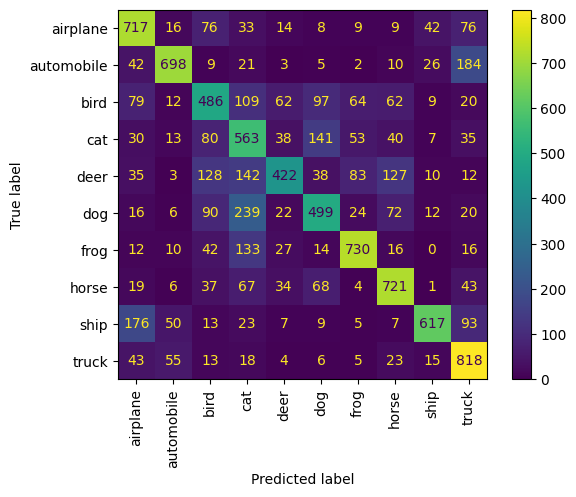

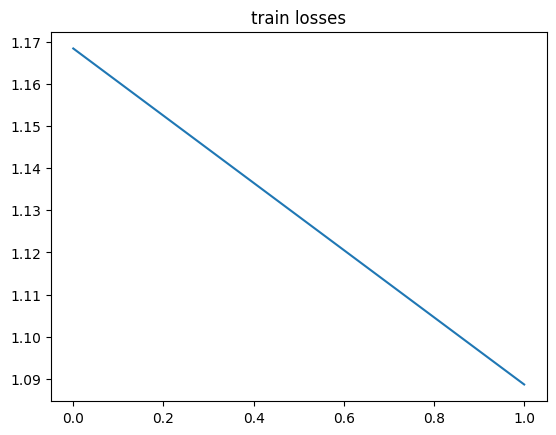

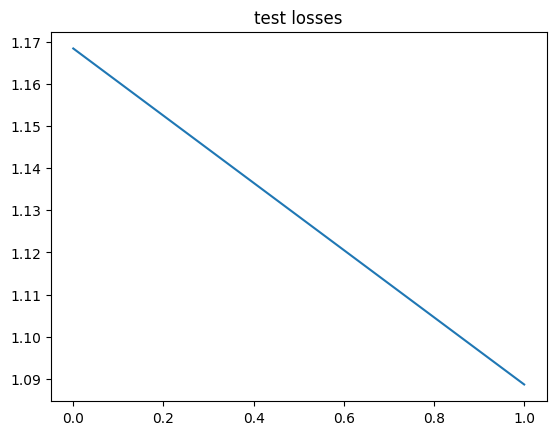

training took 53.87142586708069s


In [69]:
epochs = 2
print_every = 500 # Print loss & accuracy every...

model = single_layer_cnn(image_size, num_classes, kernel_size, stride_size, max_pool_size, device)
opt = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt, loss_function, device, print_every, disp_params=True)

### Try the more complex model.

final x,y dimnesion is: 5.0
[1,   500] | loss: 1.754 | Acc: 33.58%")
[1,  1000] | loss: 1.429 | Acc: 47.88%")
[1,  1500] | loss: 1.260 | Acc: 54.81%")
[2,   500] | loss: 1.143 | Acc: 59.61%")
[2,  1000] | loss: 1.097 | Acc: 61.59%")
[2,  1500] | loss: 1.029 | Acc: 64.04%")
Finished Epoch #2
Test value loss: 1.0114488574028015


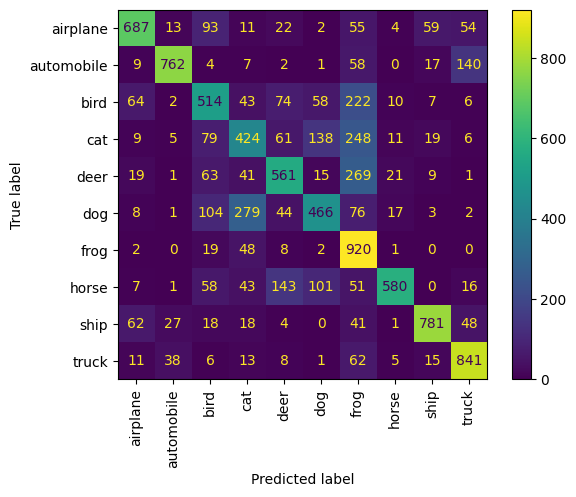

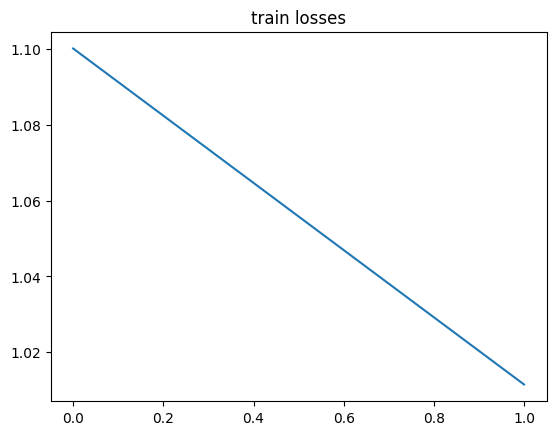

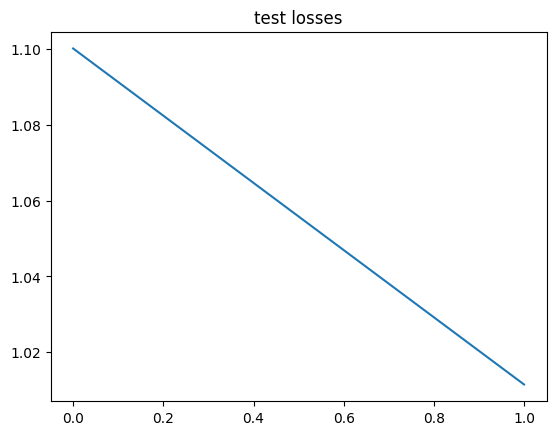

training took 65.4734308719635s


In [59]:
epochs = 2
print_every = 500 # Print loss & accuracy every...
convolution_layer_channels = [32, 64]

model = multi_layer_cnn(device, image_size, convolution_layer_channels, kernel_size, stride_size, run_batch_norm=True)
opt = optim.Adam(model.parameters(), lr=learning_rate)
if not model.model_set:    
    print("bad model")
else:    
    model.to(device)
    train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt, loss_function, device, print_every, disp_params=True)

### Run a loop on different model configurations.
We'd like to get a hunch for which hyper-parameter configurations are favorable. To save time we just look at a few epochs.

In [57]:
# Set the constants.
epochs = 5
print_every = 500 # Print loss & accuracy every...
convolution_layer_channels = [32, 64]

hyper_param_tests = [[] for i in range(3)]
model_labels = []

# define different hyper-parameters and model architechtures.
kernel_sizes = [3, 5] 
stride_sizes = [1, 2]
batch_norm_types = [False, True]

for kernel_size in kernel_sizes:
    for stride_size in stride_sizes:
        for batch_norm in batch_norm_types:
            model_label = f"kernel={kernel_size}, stride={stride_size}, batch_norm={batch_norm}"
            model_labels.append(model_label)
            print(model_label)
            model = multi_layer_cnn(device, image_size, convolution_layer_channels, kernel_size, stride_size, run_batch_norm=batch_norm)
            opt = optim.Adam(model.parameters(), lr=learning_rate)
            if not model.model_set:
                print("bad model")
            else:    
                model.to(device)
                train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt, 
                                                                 loss_function, device, print_every, disp_params=False)
                hyper_param_tests[0].append(train_losses)
                hyper_param_tests[1].append(test_losses)
                hyper_param_tests[2].append(test_accuracy)
    

kernel=3, stride=1, batch_norm=False
final x,y dimnesion is: 22.0
training took 158.53522562980652s
kernel=3, stride=1, batch_norm=True
final x,y dimnesion is: 22.0
training took 168.021222114563s
kernel=3, stride=2, batch_norm=False
final x,y dimnesion is: 5.0
training took 158.69592595100403s
kernel=3, stride=2, batch_norm=True
final x,y dimnesion is: 5.0
training took 159.5331838130951s
kernel=5, stride=1, batch_norm=False
final x,y dimnesion is: 14.0
training took 163.94677233695984s
kernel=5, stride=1, batch_norm=True
final x,y dimnesion is: 14.0
training took 171.8663411140442s
kernel=5, stride=2, batch_norm=False
final x,y dimnesion is: 2.0
training took 158.83209919929504s
kernel=5, stride=2, batch_norm=True
final x,y dimnesion is: 2.0
training took 165.31863164901733s


### Check the model configurations test results.

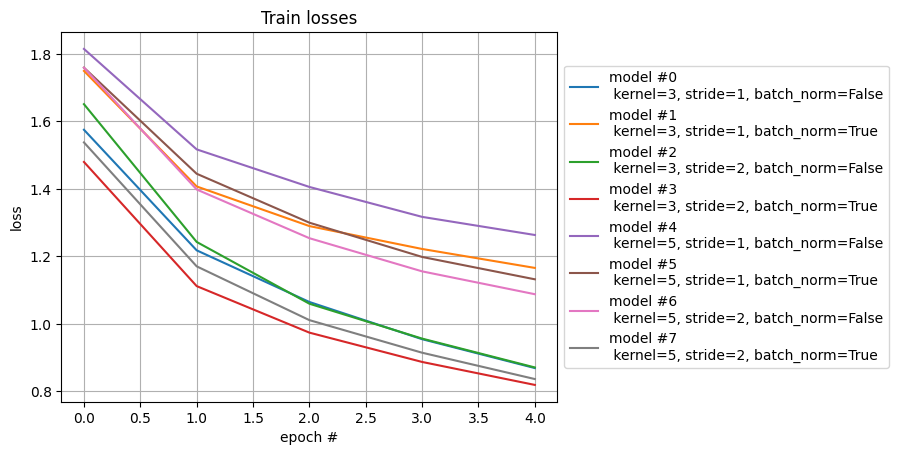

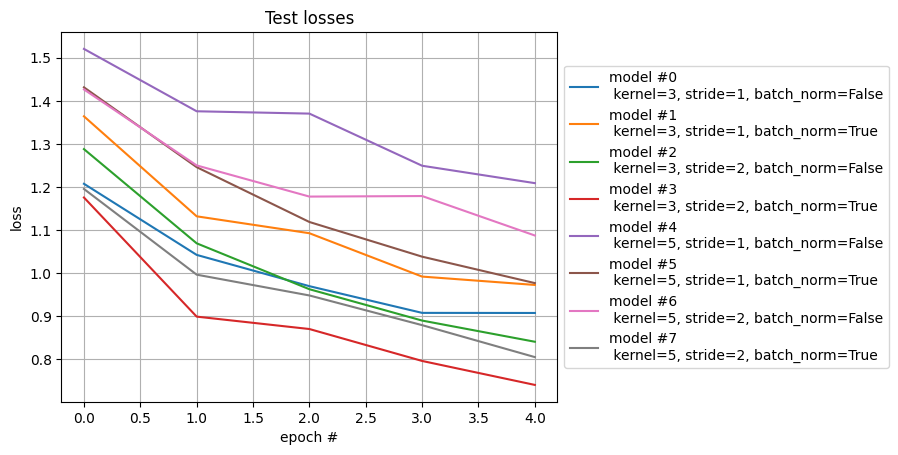

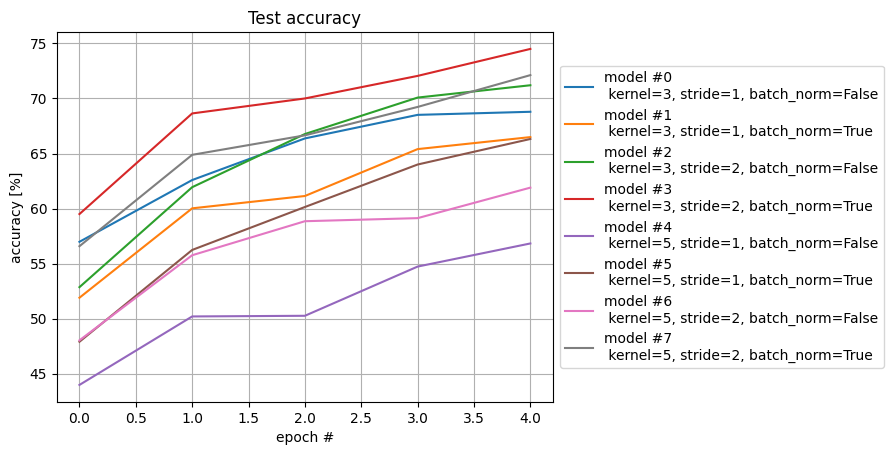

In [58]:
def compare_model_results(test_results, labels):
    fig1 = plt.figure(1)
    fig1 = plt.figure(2)
    fig3 = plt.figure(3)
    
    for h in range(len(test_results[0])):
        plt.figure(1)
        plt.plot(test_results[0][h], label=f"model #{h}\n {labels[h]}")
        plt.figure(2)
        plt.plot(test_results[1][h], label=f"model #{h}\n {labels[h]}")
        plt.figure(3)
        plt.plot(test_results[2][h], label=f"model #{h}\n {labels[h]}")
    
    plt.figure(1)
    plt.title("Train losses")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.xlabel("epoch #")
    plt.ylabel("loss")
    
    plt.figure(2)
    plt.title("Test losses")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.xlabel("epoch #")
    plt.ylabel("loss")
    
    plt.figure(3)
    plt.title("Test accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.xlabel("epoch #")
    plt.ylabel("accuracy [%]")

compare_model_results(hyper_param_tests, model_labels)
    

### Analysis
It is clear that the results are improved when using batch norm 2d and a stride of 2 instead of 1, using either 3 or 5 for kernel size choice.
To focus on kernel size comparison, we'll perform another test below with a few more epochs.

Note that training time doesn't differ significantly for different model configurations. 

kernel=3, stride=2, batch_norm=True
kernel=5, stride=2, batch_norm=True


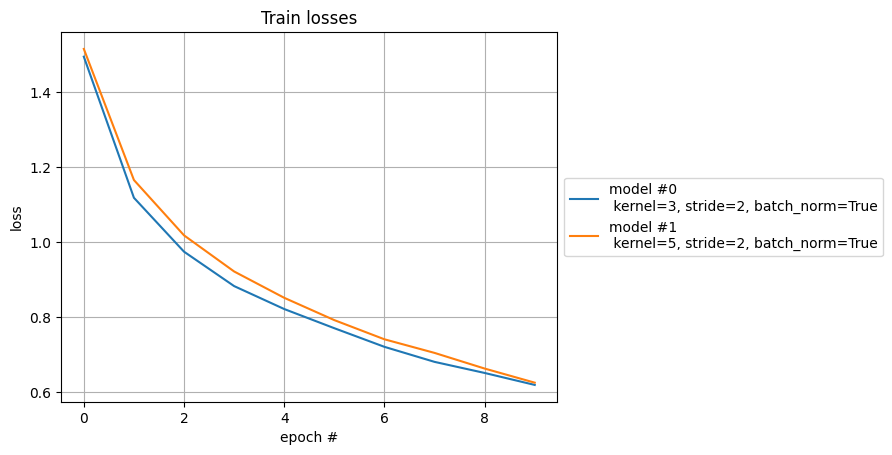

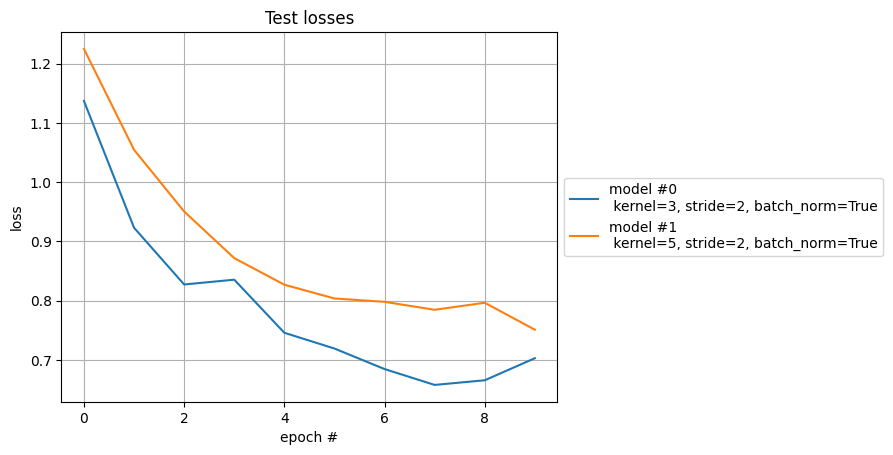

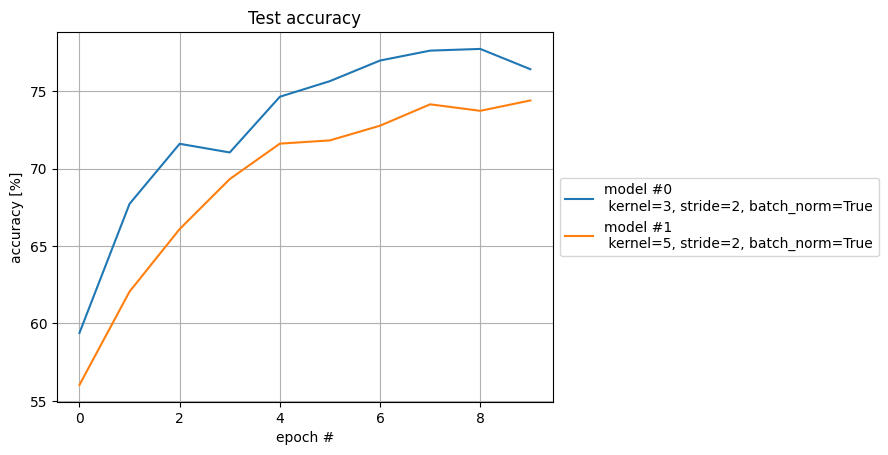

In [56]:
# Set the constants.
epochs = 10
print_every = 500 # Print loss & accuracy every...
convolution_layer_channels = [32, 64]

# hyper_param_tests_2 = [[] for i in range(3)]
model_labels_2 = []

# define different hyper-parameters and model architechtures.
kernel_sizes = [3, 5] 
stride_sizes = [2]
batch_norm_types = [True]

for kernel_size in kernel_sizes:
    for stride_size in stride_sizes:
        for batch_norm in batch_norm_types:
            model_label = f"kernel={kernel_size}, stride={stride_size}, batch_norm={batch_norm}"
            model_labels_2.append(model_label)
            print(model_label)
            model = multi_layer_cnn(device, image_size, convolution_layer_channels, kernel_size, stride_size, run_batch_norm=batch_norm)
            opt = optim.Adam(model.parameters(), lr=learning_rate)
            if not model.model_set:
                print("bad model")
            else:    
                model.to(device)
                train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt,
                                                                 loss_function, device, print_every, disp_params=False)
                hyper_param_tests_2[0].append(train_losses)
                hyper_param_tests_2[1].append(test_losses)
                hyper_param_tests_2[2].append(test_accuracy)

compare_model_results(hyper_param_tests_2, model_labels_2)

#### Using the 3x3 kernel seems to give better results. We'll try to run with the "best" model configuration for 30 epochs.

final x,y dimnesion is: 5.0
[1,   500] | loss: 1.778 | Acc: 32.99%")
[1,  1000] | loss: 1.471 | Acc: 46.32%")
[1,  1500] | loss: 1.307 | Acc: 53.23%")
[2,   500] | loss: 1.176 | Acc: 58.28%")
[2,  1000] | loss: 1.106 | Acc: 61.97%")
[2,  1500] | loss: 1.087 | Acc: 62.14%")
[3,   500] | loss: 0.985 | Acc: 65.17%")
[3,  1000] | loss: 0.981 | Acc: 66.16%")
[3,  1500] | loss: 0.951 | Acc: 67.06%")
[4,   500] | loss: 0.904 | Acc: 68.84%")
[4,  1000] | loss: 0.902 | Acc: 68.96%")
[4,  1500] | loss: 0.878 | Acc: 69.98%")
[5,   500] | loss: 0.848 | Acc: 71.05%")
[5,  1000] | loss: 0.828 | Acc: 71.60%")
[5,  1500] | loss: 0.829 | Acc: 71.58%")
[6,   500] | loss: 0.784 | Acc: 73.05%")
[6,  1000] | loss: 0.787 | Acc: 73.08%")
[6,  1500] | loss: 0.784 | Acc: 73.58%")
[7,   500] | loss: 0.735 | Acc: 75.01%")
[7,  1000] | loss: 0.745 | Acc: 74.47%")
[7,  1500] | loss: 0.752 | Acc: 74.59%")
[8,   500] | loss: 0.696 | Acc: 76.16%")
[8,  1000] | loss: 0.711 | Acc: 75.81%")
[8,  1500] | loss: 0.711 | Ac

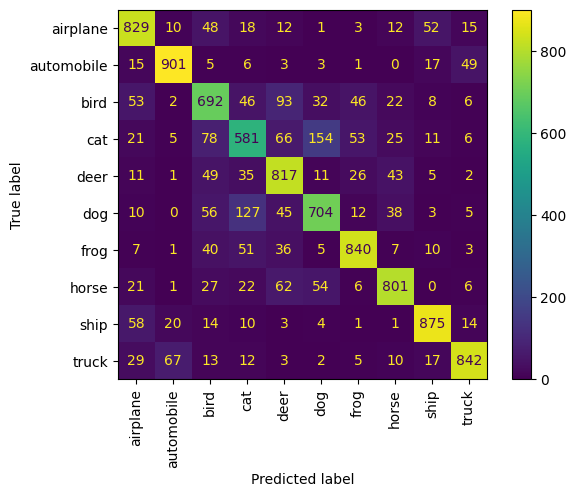

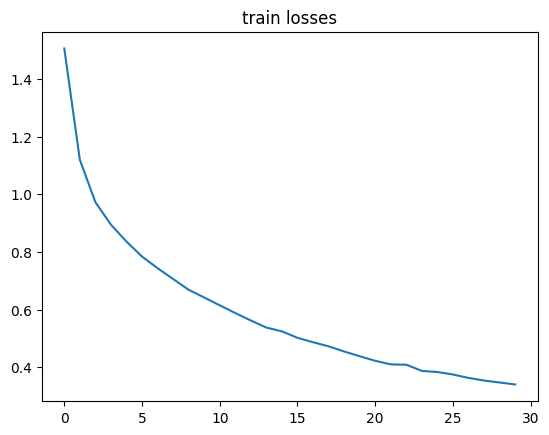

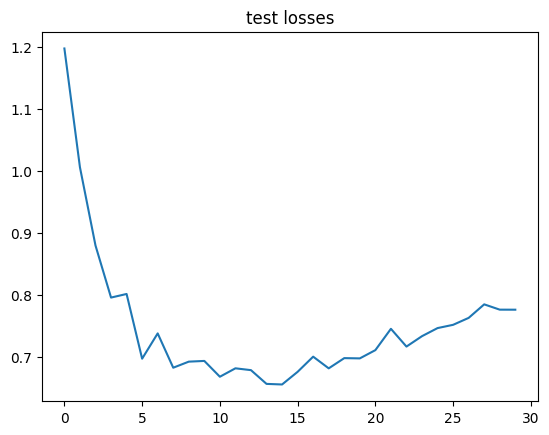

training took 972.6139769554138s


In [82]:
epochs = 30
print_every = 500 # Print loss & accuracy every...
convolution_layer_channels = [32, 64]
kernel_size = 3 
stride_size = 2

model = multi_layer_cnn(device, image_size, convolution_layer_channels, kernel_size, stride_size, run_batch_norm=True)
opt = optim.Adam(model.parameters(), lr=learning_rate)
if not model.model_set:
    print("bad model")
else:    
    model.to(device)
    train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt, loss_function, device, print_every, disp_params=True)

In [ ]:
compare_model_results([[train_losses], [test_losses], [test_accuracy]]) 

### Mid-summary.
It's clear from the above that there's a case of over-fitting to the training data, where test loss increases after 15 epochs while train loss decreases.
Several method to fix this could be:
1) Add more dropout layers between convolution layers.
2) Add more convolution layers.
3) Data augmentation.

Let's try data augmentation to improve the results.

In [97]:
# Set a new transform for the training data.
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
         # degrees=0,  # No rotation
         # translate=(0.1, 0.1), # Max horizontal/vertical shift of 10% of image height
         # scale=(1.0, 1.0), # No scaling
         # shear=0), # No shearing
     transforms.ToTensor(), # normalizes to 0 to 1 range.
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2023, 0.1994, 0.2010))]) 

# Define the dataset/loader
train_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# # Save the last configuration of the model.
# model_path = ("./cifar10_model_without_data_augmentation")
# torch.save(model.state_dict(), model_path)

final x,y dimnesion is: 5.0
[1,   500] | loss: 0.616 | Train Acc: 81.26%")
[1,  1000] | loss: 0.580 | Train Acc: 81.42%")
[1,  1500] | loss: 0.587 | Train Acc: 80.98%")
Finished Epoch #1
Test value loss: 0.6388261710882187 | Test Acc: 78.93%
[2,   500] | loss: 0.557 | Train Acc: 82.07%")
[2,  1000] | loss: 0.557 | Train Acc: 81.85%")
[2,  1500] | loss: 0.566 | Train Acc: 81.42%")
Finished Epoch #2
Test value loss: 0.614847349357605 | Test Acc: 79.59%
[3,   500] | loss: 0.534 | Train Acc: 82.62%")
[3,  1000] | loss: 0.545 | Train Acc: 82.31%")
[3,  1500] | loss: 0.551 | Train Acc: 82.08%")
Finished Epoch #3
Test value loss: 0.6242801721096038 | Test Acc: 80.05%
[4,   500] | loss: 0.526 | Train Acc: 82.88%")
[4,  1000] | loss: 0.524 | Train Acc: 83.22%")
[4,  1500] | loss: 0.534 | Train Acc: 82.93%")
Finished Epoch #4
Test value loss: 0.6451997197628021 | Test Acc: 79.89%
[5,   500] | loss: 0.512 | Train Acc: 83.09%")
[5,  1000] | loss: 0.532 | Train Acc: 82.42%")
[5,  1500] | loss: 0.51

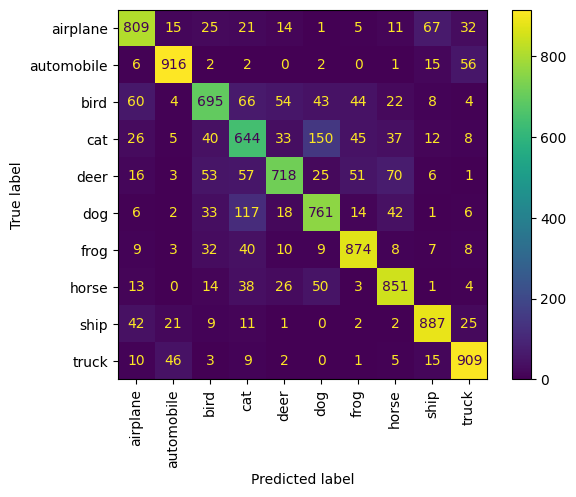

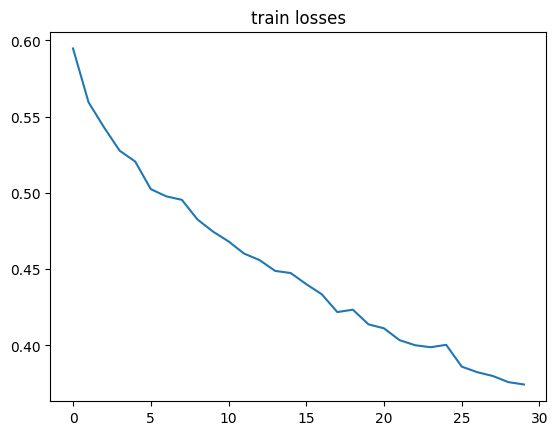

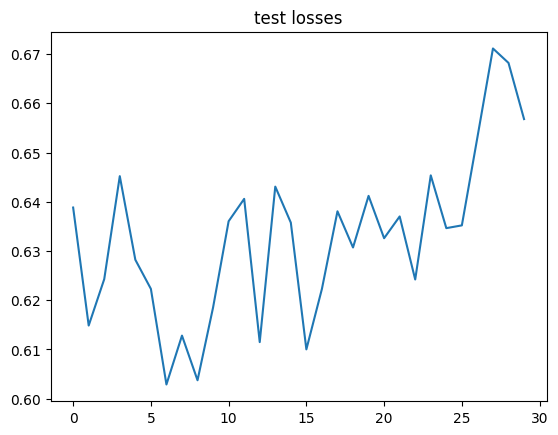

training took 1028.0005481243134s


In [103]:
epochs = 30
print_every = 500 # Print loss & accuracy every...

model = multi_layer_cnn(device, image_size, convolution_layer_channels, kernel_size, stride_size, run_batch_norm=True)
model.load_state_dict(torch.load('./cifar10_model_without_data_augmentation', weights_only=True))
opt = optim.Adam(model.parameters(), lr=learning_rate)
if not model.model_set:
    print("bad model")
else:    
    model.to(device)
    train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, opt, loss_function, device, print_every, disp_params=True)

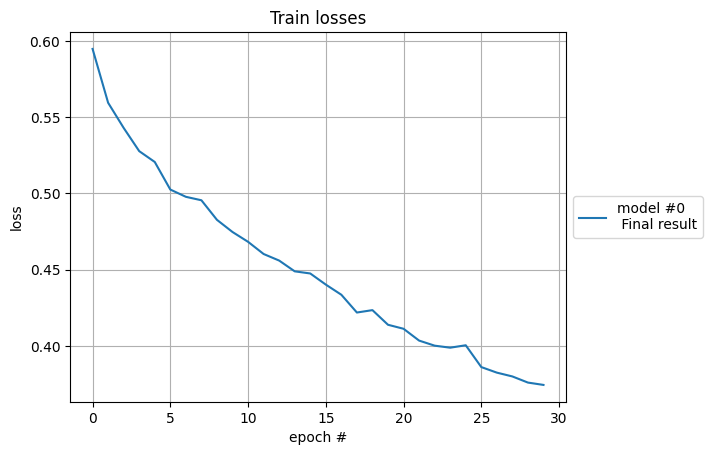

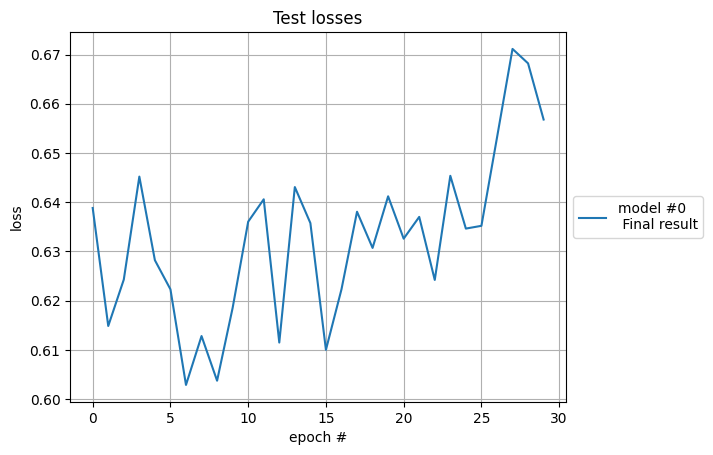

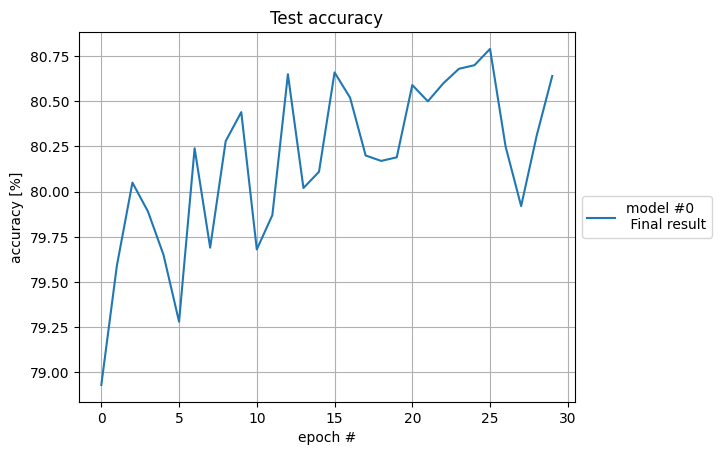

In [105]:
compare_model_results([[train_losses], [test_losses], [test_accuracy]], ['Final result']) 
model_path = ("./cifar10_model_with_data_augmentation")
torch.save(model.state_dict(), model_path)

### Final summary.
Final test accuracy is a bit over 80%. For longer runs it's able to reach near 85%. 
Ultimately the model is probably too shallow to capture all the necessary features. Moreover, the fact the training accuracy is substantially above test accuracy indicates that adding more data augmentation operations would probably help as well.
